In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
from glob import glob
import os

In [2]:
import tensorflow as tf
import numpy as np

/usr/local/lib/python2.7/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [3]:
tf.__version__

'1.5.0'

In [55]:
image_path = [
    "00003102d3ec9a46cb5cd2fd95473b8d.jpg",
    "imgs/73a302074e5e8afa9a223563457b8fce"
]

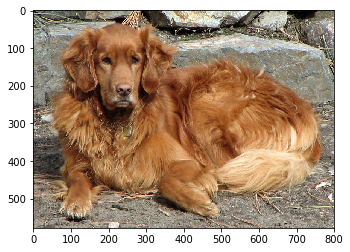

In [56]:
from PIL import Image
plt.imshow(Image.open(image_path[0]))

In [29]:
ResNet50 = tf.keras.applications.ResNet50
preprocess_input = tf.keras.applications.resnet50.preprocess_input
image = tf.keras.preprocessing.image

In [30]:
resnet_model = ResNet50(weights='imagenet', include_top=False)

In [57]:
def extract_features(img_path):
    img = image.load_img(img_path, target_size=(224, 224))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    return resnet_model.predict(x)[0][0][0]

In [59]:
f = []
for i in image_path:
    f.append(extract_features(i))
#     print(f[:5])
#     print(len(f))

In [60]:
size = 256

In [61]:
small_out = image.load_img(image_path[0], target_size=(size, size))

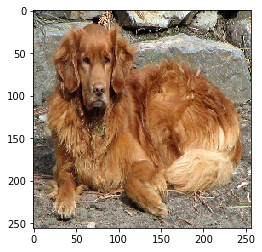

In [62]:
plt.imshow(small_out)

In [63]:
Input = tf.keras.layers.Input
Dense = tf.keras.layers.Dense
Conv2D = tf.keras.layers.Conv2D
MaxPooling2D = tf.keras.layers.MaxPooling2D
UpSampling2D = tf.keras.layers.UpSampling2D
Cropping2D = tf.keras.layers.Cropping2D
Conv2DTranspose = tf.keras.layers.Conv2DTranspose
BatchNormalization = tf.keras.layers.BatchNormalization
LeakyReLU = tf.keras.layers.LeakyReLU
Model = tf.keras.models.Model
Reshape = tf.keras.layers.Reshape
Adam = tf.keras.optimizers.Adam
#from tf.keras import backend as K

In [64]:
def conv_only():
    input_img = Input(shape=(2048, ))  # adapt this if using `channels_first` image data format

    x = Reshape([4, 4, 128] )(input_img)
    x = Conv2DTranspose(2048, (4, 4), activation='relu', padding='same', strides=(2, 2))(x)
    #x = Cropping2D(((1, 1), (1, 1)))(x)
    #x = BatchNormalization()(x)
    x = Conv2DTranspose(1024, (4, 4), activation='relu', padding='same', strides=(2, 2))(x)
    #x = Cropping2D(((1, 1), (1, 1)))(x)
    #x = BatchNormalization()(x)
    x = Conv2DTranspose(512, (4, 4), activation='relu', padding='same', strides=(2, 2))(x)
    #x = Cropping2D(((1, 1), (1, 1)))(x)
    #x = BatchNormalization()(x)
    x = Conv2DTranspose(256, (4, 4), activation='relu', padding='same', strides=(2, 2))(x)
    #x = Cropping2D(((1, 1), (1, 1)))(x)
    #x = BatchNormalization()(x)
    x = Conv2DTranspose(128, (4, 4), activation='relu', padding='same', strides=(2, 2))(x)
    #x = Cropping2D(((1, 1), (1, 1)))(x)
    #x = BatchNormalization()(x)
    x = Conv2DTranspose(64, (4, 4), activation='relu', padding='same', strides=(2, 2))(x)
    #x = Cropping2D(((1, 1), (1, 1)))(x)
    #x = BatchNormalization()(x)
    decoded = Conv2D(3, (4, 4), activation='sigmoid', padding='same')(x)

In [65]:
conv_size = (3, 3)
leaku_relu_alpha = 0.2

input_img = Input(shape=(2048, )) 
x = Reshape([4, 4, 128] )(input_img)
x = Conv2D(2048, conv_size, padding='same')(x) #activation='relu',
x = LeakyReLU(leaku_relu_alpha)(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(1024, conv_size, padding='same')(x)
x = LeakyReLU(leaku_relu_alpha)(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(512, conv_size, padding='same')(x)
x = LeakyReLU(leaku_relu_alpha)(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(256, conv_size, padding='same')(x)
x = LeakyReLU(leaku_relu_alpha)(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(128, conv_size, padding='same')(x)
x = LeakyReLU(leaku_relu_alpha)(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(64, conv_size, padding='same')(x)
x = LeakyReLU(leaku_relu_alpha)(x)
x = UpSampling2D((2, 2))(x)
decoded = Conv2D(3, (2, 2), activation='sigmoid', padding='same')(x)
#decoded = Conv2D(3, (2, 2), activation='tanh', padding='same')(x)

In [66]:
autoencoder = Model(input_img, decoded)
#optimizer = Adam(lr=0.001)  # lr=1e-3
#autoencoder.compile(optimizer=optimizer, loss='binary_crossentropy')
#autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy')
autoencoder.compile(optimizer="adadelta", loss='binary_crossentropy')

In [67]:
autoencoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         (None, 2048)              0         
_________________________________________________________________
reshape_4 (Reshape)          (None, 4, 4, 128)         0         
_________________________________________________________________
conv2d_22 (Conv2D)           (None, 4, 4, 2048)        2361344   
_________________________________________________________________
leaky_re_lu_19 (LeakyReLU)   (None, 4, 4, 2048)        0         
_________________________________________________________________
up_sampling2d_19 (UpSampling (None, 8, 8, 2048)        0         
_________________________________________________________________
conv2d_23 (Conv2D)           (None, 8, 8, 1024)        18875392  
_________________________________________________________________
leaky_re_lu_20 (LeakyReLU)   (None, 8, 8, 1024)        0         
__________

In [83]:
images = []
for i in image_path:
    images.append(image.img_to_array(image.load_img(i, target_size=(size, size))))
images = np.reshape(images, (len(images), size, size, 3)).astype('float32') / 255.

In [84]:
images

array([[[[0.20784314, 0.20392157, 0.18431373],
         [0.24313726, 0.28235295, 0.2509804 ],
         [0.48235294, 0.5529412 , 0.5058824 ],
         ...,
         [0.47058824, 0.4392157 , 0.35686275],
         [0.4117647 , 0.38039216, 0.2901961 ],
         [0.4117647 , 0.38039216, 0.2901961 ]],

        [[0.18431373, 0.14901961, 0.11372549],
         [0.05490196, 0.05882353, 0.03529412],
         [0.22745098, 0.2784314 , 0.24313726],
         ...,
         [0.5254902 , 0.5019608 , 0.41568628],
         [0.48235294, 0.45882353, 0.37254903],
         [0.47058824, 0.44705883, 0.3529412 ]],

        [[0.3372549 , 0.27058825, 0.24313726],
         [0.27450982, 0.24313726, 0.23137255],
         [0.08235294, 0.09803922, 0.09411765],
         ...,
         [0.46666667, 0.4392157 , 0.3647059 ],
         [0.50980395, 0.4862745 , 0.4       ],
         [0.4509804 , 0.42745098, 0.34117648]],

        ...,

        [[0.69411767, 0.67058825, 0.60784316],
         [0.7647059 , 0.7176471 , 0.6627451 ]

In [88]:
# TensorBoard = tf.keras.callbacks.TensorBoard

autoencoder.fit(np.array(f), 
                images,
                epochs=4000,
                batch_size=128,
                shuffle=True,
               )
                #validation_data=(x_test, x_test),
                #callbacks=[TensorBoard(log_dir='/tmp/autoencoder')])

Epoch 1/4000
2/2 [==============================]2/2 [==============================] - 2s 866ms/step - loss: 0.6968

Epoch 2/4000
2/2 [==============================]2/2 [==============================] - 0s 40ms/step - loss: 0.6076

Epoch 3/4000
2/2 [==============================]2/2 [==============================] - 0s 40ms/step - loss: 0.6737

Epoch 4/4000
2/2 [==============================]2/2 [==============================] - 0s 40ms/step - loss: 0.5877

Epoch 5/4000
2/2 [==============================]2/2 [==============================] - 0s 41ms/step - loss: 0.6179

Epoch 6/4000
2/2 [==============================]2/2 [==============================] - 0s 41ms/step - loss: 0.6536

Epoch 7/4000
2/2 [==============================]2/2 [==============================] - 0s 40ms/step - loss: 0.5558

Epoch 8/4000
2/2 [==============================]2/2 [==============================] - 0s 41ms/step - loss: 0.5012

Epoch 9/4000
2/2 [==============================]2/2 [=========


Epoch 71/4000
2/2 [==============================]2/2 [==============================] - 0s 41ms/step - loss: 0.4659

Epoch 72/4000
2/2 [==============================]2/2 [==============================] - 0s 40ms/step - loss: 0.4652

Epoch 73/4000
2/2 [==============================]2/2 [==============================] - 0s 40ms/step - loss: 0.4657

Epoch 74/4000
2/2 [==============================]2/2 [==============================] - 0s 40ms/step - loss: 0.4649

Epoch 75/4000
2/2 [==============================]2/2 [==============================] - 0s 42ms/step - loss: 0.4653

Epoch 76/4000
2/2 [==============================]2/2 [==============================] - 0s 40ms/step - loss: 0.4646

Epoch 77/4000
2/2 [==============================]2/2 [==============================] - 0s 41ms/step - loss: 0.4650

Epoch 78/4000
2/2 [==============================]2/2 [==============================] - 0s 41ms/step - loss: 0.4642

Epoch 79/4000
2/2 [==============================]2/2 [

2/2 [==============================]2/2 [==============================] - 0s 40ms/step - loss: 0.4585

Epoch 141/4000
2/2 [==============================]2/2 [==============================] - 0s 40ms/step - loss: 0.4588

Epoch 142/4000
2/2 [==============================]2/2 [==============================] - 0s 39ms/step - loss: 0.4586

Epoch 143/4000
2/2 [==============================]2/2 [==============================] - 0s 41ms/step - loss: 0.4582

Epoch 144/4000
2/2 [==============================]2/2 [==============================] - 0s 42ms/step - loss: 0.4575

Epoch 145/4000
2/2 [==============================]2/2 [==============================] - 0s 39ms/step - loss: 0.4577

Epoch 146/4000
2/2 [==============================]2/2 [==============================] - 0s 42ms/step - loss: 0.4571

Epoch 147/4000
2/2 [==============================]2/2 [==============================] - 0s 40ms/step - loss: 0.4575

Epoch 148/4000
2/2 [==============================]2/2 [=======


Epoch 209/4000
2/2 [==============================]2/2 [==============================] - 0s 42ms/step - loss: 0.4580

Epoch 210/4000
2/2 [==============================]2/2 [==============================] - 0s 42ms/step - loss: 0.4564

Epoch 211/4000
2/2 [==============================]2/2 [==============================] - 0s 40ms/step - loss: 0.4554

Epoch 212/4000
2/2 [==============================]2/2 [==============================] - 0s 39ms/step - loss: 0.4543

Epoch 213/4000
2/2 [==============================]2/2 [==============================] - 0s 40ms/step - loss: 0.4545

Epoch 214/4000
2/2 [==============================]2/2 [==============================] - 0s 42ms/step - loss: 0.4539

Epoch 215/4000
2/2 [==============================]2/2 [==============================] - 0s 40ms/step - loss: 0.4542

Epoch 216/4000
2/2 [==============================]2/2 [==============================] - 0s 40ms/step - loss: 0.4538

Epoch 217/4000
2/2 [===========================


Epoch 278/4000
2/2 [==============================]2/2 [==============================] - 0s 40ms/step - loss: 0.4510

Epoch 279/4000
2/2 [==============================]2/2 [==============================] - 0s 41ms/step - loss: 0.4511

Epoch 280/4000
2/2 [==============================]2/2 [==============================] - 0s 41ms/step - loss: 0.4509

Epoch 281/4000
2/2 [==============================]2/2 [==============================] - 0s 39ms/step - loss: 0.4510

Epoch 282/4000
2/2 [==============================]2/2 [==============================] - 0s 41ms/step - loss: 0.4509

Epoch 283/4000
2/2 [==============================]2/2 [==============================] - 0s 39ms/step - loss: 0.4510

Epoch 284/4000
2/2 [==============================]2/2 [==============================] - 0s 40ms/step - loss: 0.4507

Epoch 285/4000
2/2 [==============================]2/2 [==============================] - 0s 41ms/step - loss: 0.4508

Epoch 286/4000
2/2 [===========================


Epoch 347/4000
2/2 [==============================]2/2 [==============================] - 0s 41ms/step - loss: 0.4496

Epoch 348/4000
2/2 [==============================]2/2 [==============================] - 0s 41ms/step - loss: 0.4494

Epoch 349/4000
2/2 [==============================]2/2 [==============================] - 0s 40ms/step - loss: 0.4495

Epoch 350/4000
2/2 [==============================]2/2 [==============================] - 0s 42ms/step - loss: 0.4494

Epoch 351/4000
2/2 [==============================]2/2 [==============================] - 0s 42ms/step - loss: 0.4494

Epoch 352/4000
2/2 [==============================]2/2 [==============================] - 0s 40ms/step - loss: 0.4492

Epoch 353/4000
2/2 [==============================]2/2 [==============================] - 0s 38ms/step - loss: 0.4492

Epoch 354/4000
2/2 [==============================]2/2 [==============================] - 0s 43ms/step - loss: 0.4491

Epoch 355/4000
2/2 [===========================


Epoch 416/4000
2/2 [==============================]2/2 [==============================] - 0s 41ms/step - loss: 0.4479

Epoch 417/4000
2/2 [==============================]2/2 [==============================] - 0s 40ms/step - loss: 0.4480

Epoch 418/4000
2/2 [==============================]2/2 [==============================] - 0s 41ms/step - loss: 0.4480

Epoch 419/4000
2/2 [==============================]2/2 [==============================] - 0s 39ms/step - loss: 0.4481

Epoch 420/4000
2/2 [==============================]2/2 [==============================] - 0s 44ms/step - loss: 0.4481

Epoch 421/4000
2/2 [==============================]2/2 [==============================] - 0s 41ms/step - loss: 0.4482

Epoch 422/4000
2/2 [==============================]2/2 [==============================] - 0s 41ms/step - loss: 0.4482

Epoch 423/4000
2/2 [==============================]2/2 [==============================] - 0s 42ms/step - loss: 0.4481

Epoch 424/4000
2/2 [===========================


Epoch 485/4000
2/2 [==============================]2/2 [==============================] - 0s 40ms/step - loss: 0.4472

Epoch 486/4000
2/2 [==============================]2/2 [==============================] - 0s 40ms/step - loss: 0.4471

Epoch 487/4000
2/2 [==============================]2/2 [==============================] - 0s 43ms/step - loss: 0.4472

Epoch 488/4000
2/2 [==============================]2/2 [==============================] - 0s 42ms/step - loss: 0.4471

Epoch 489/4000
2/2 [==============================]2/2 [==============================] - 0s 41ms/step - loss: 0.4471

Epoch 490/4000
2/2 [==============================]2/2 [==============================] - 0s 39ms/step - loss: 0.4471

Epoch 491/4000
2/2 [==============================]2/2 [==============================] - 0s 40ms/step - loss: 0.4471

Epoch 492/4000
2/2 [==============================]2/2 [==============================] - 0s 41ms/step - loss: 0.4470

Epoch 493/4000
2/2 [===========================


Epoch 554/4000
2/2 [==============================]2/2 [==============================] - 0s 41ms/step - loss: 0.4461

Epoch 555/4000
2/2 [==============================]2/2 [==============================] - 0s 40ms/step - loss: 0.4462

Epoch 556/4000
2/2 [==============================]2/2 [==============================] - 0s 40ms/step - loss: 0.4461

Epoch 557/4000
2/2 [==============================]2/2 [==============================] - 0s 41ms/step - loss: 0.4462

Epoch 558/4000
2/2 [==============================]2/2 [==============================] - 0s 39ms/step - loss: 0.4462

Epoch 559/4000
2/2 [==============================]2/2 [==============================] - 0s 41ms/step - loss: 0.4462

Epoch 560/4000
2/2 [==============================]2/2 [==============================] - 0s 41ms/step - loss: 0.4463

Epoch 561/4000
2/2 [==============================]2/2 [==============================] - 0s 42ms/step - loss: 0.4463

Epoch 562/4000
2/2 [===========================


Epoch 623/4000
2/2 [==============================]2/2 [==============================] - 0s 40ms/step - loss: 0.4460

Epoch 624/4000
2/2 [==============================]2/2 [==============================] - 0s 40ms/step - loss: 0.4459

Epoch 625/4000
2/2 [==============================]2/2 [==============================] - 0s 42ms/step - loss: 0.4458

Epoch 626/4000
2/2 [==============================]2/2 [==============================] - 0s 42ms/step - loss: 0.4457

Epoch 627/4000
2/2 [==============================]2/2 [==============================] - 0s 41ms/step - loss: 0.4456

Epoch 628/4000
2/2 [==============================]2/2 [==============================] - 0s 40ms/step - loss: 0.4455

Epoch 629/4000
2/2 [==============================]2/2 [==============================] - 0s 40ms/step - loss: 0.4455

Epoch 630/4000
2/2 [==============================]2/2 [==============================] - 0s 41ms/step - loss: 0.4454

Epoch 631/4000
2/2 [===========================


Epoch 692/4000
2/2 [==============================]2/2 [==============================] - 0s 41ms/step - loss: 0.4451

Epoch 693/4000
2/2 [==============================]2/2 [==============================] - 0s 41ms/step - loss: 0.4452

Epoch 694/4000
2/2 [==============================]2/2 [==============================] - 0s 38ms/step - loss: 0.4452

Epoch 695/4000
2/2 [==============================]2/2 [==============================] - 0s 43ms/step - loss: 0.4453

Epoch 696/4000
2/2 [==============================]2/2 [==============================] - 0s 42ms/step - loss: 0.4453

Epoch 697/4000
2/2 [==============================]2/2 [==============================] - 0s 41ms/step - loss: 0.4455

Epoch 698/4000
2/2 [==============================]2/2 [==============================] - 0s 40ms/step - loss: 0.4455

Epoch 699/4000
2/2 [==============================]2/2 [==============================] - 0s 39ms/step - loss: 0.4456

Epoch 700/4000
2/2 [===========================


Epoch 761/4000
2/2 [==============================]2/2 [==============================] - 0s 41ms/step - loss: 0.4442

Epoch 762/4000
2/2 [==============================]2/2 [==============================] - 0s 40ms/step - loss: 0.4442

Epoch 763/4000
2/2 [==============================]2/2 [==============================] - 0s 41ms/step - loss: 0.4442

Epoch 764/4000
2/2 [==============================]2/2 [==============================] - 0s 41ms/step - loss: 0.4443

Epoch 765/4000
2/2 [==============================]2/2 [==============================] - 0s 40ms/step - loss: 0.4445

Epoch 766/4000
2/2 [==============================]2/2 [==============================] - 0s 41ms/step - loss: 0.4447

Epoch 767/4000
2/2 [==============================]2/2 [==============================] - 0s 41ms/step - loss: 0.4449

Epoch 768/4000
2/2 [==============================]2/2 [==============================] - 0s 40ms/step - loss: 0.4452

Epoch 769/4000
2/2 [===========================


Epoch 830/4000
2/2 [==============================]2/2 [==============================] - 0s 41ms/step - loss: 0.4442

Epoch 831/4000
2/2 [==============================]2/2 [==============================] - 0s 40ms/step - loss: 0.4442

Epoch 832/4000
2/2 [==============================]2/2 [==============================] - 0s 41ms/step - loss: 0.4442

Epoch 833/4000
2/2 [==============================]2/2 [==============================] - 0s 41ms/step - loss: 0.4441

Epoch 834/4000
2/2 [==============================]2/2 [==============================] - 0s 41ms/step - loss: 0.4441

Epoch 835/4000
2/2 [==============================]2/2 [==============================] - 0s 41ms/step - loss: 0.4441

Epoch 836/4000
2/2 [==============================]2/2 [==============================] - 0s 38ms/step - loss: 0.4441

Epoch 837/4000
2/2 [==============================]2/2 [==============================] - 0s 41ms/step - loss: 0.4441

Epoch 838/4000
2/2 [===========================


Epoch 899/4000
2/2 [==============================]2/2 [==============================] - 0s 40ms/step - loss: 0.4438

Epoch 900/4000
2/2 [==============================]2/2 [==============================] - 0s 42ms/step - loss: 0.4439

Epoch 901/4000
2/2 [==============================]2/2 [==============================] - 0s 41ms/step - loss: 0.4438

Epoch 902/4000
2/2 [==============================]2/2 [==============================] - 0s 40ms/step - loss: 0.4438

Epoch 903/4000
2/2 [==============================]2/2 [==============================] - 0s 43ms/step - loss: 0.4437

Epoch 904/4000
2/2 [==============================]2/2 [==============================] - 0s 41ms/step - loss: 0.4437

Epoch 905/4000
2/2 [==============================]2/2 [==============================] - 0s 39ms/step - loss: 0.4437

Epoch 906/4000
2/2 [==============================]2/2 [==============================] - 0s 44ms/step - loss: 0.4436

Epoch 907/4000
2/2 [===========================


Epoch 968/4000
2/2 [==============================]2/2 [==============================] - 0s 41ms/step - loss: 0.4435

Epoch 969/4000
2/2 [==============================]2/2 [==============================] - 0s 42ms/step - loss: 0.4435

Epoch 970/4000
2/2 [==============================]2/2 [==============================] - 0s 42ms/step - loss: 0.4435

Epoch 971/4000
2/2 [==============================]2/2 [==============================] - 0s 40ms/step - loss: 0.4434

Epoch 972/4000
2/2 [==============================]2/2 [==============================] - 0s 41ms/step - loss: 0.4434

Epoch 973/4000
2/2 [==============================]2/2 [==============================] - 0s 41ms/step - loss: 0.4434

Epoch 974/4000
2/2 [==============================]2/2 [==============================] - 0s 40ms/step - loss: 0.4434

Epoch 975/4000
2/2 [==============================]2/2 [==============================] - 0s 38ms/step - loss: 0.4433

Epoch 976/4000
2/2 [===========================


Epoch 1037/4000
2/2 [==============================]2/2 [==============================] - 0s 42ms/step - loss: 0.4432

Epoch 1038/4000
2/2 [==============================]2/2 [==============================] - 0s 40ms/step - loss: 0.4432

Epoch 1039/4000
2/2 [==============================]2/2 [==============================] - 0s 40ms/step - loss: 0.4431

Epoch 1040/4000
2/2 [==============================]2/2 [==============================] - 0s 41ms/step - loss: 0.4432

Epoch 1041/4000
2/2 [==============================]2/2 [==============================] - 0s 41ms/step - loss: 0.4431

Epoch 1042/4000
2/2 [==============================]2/2 [==============================] - 0s 40ms/step - loss: 0.4432

Epoch 1043/4000
2/2 [==============================]2/2 [==============================] - 0s 40ms/step - loss: 0.4431

Epoch 1044/4000
2/2 [==============================]2/2 [==============================] - 0s 40ms/step - loss: 0.4431

Epoch 1045/4000
2/2 [==================


Epoch 1106/4000
2/2 [==============================]2/2 [==============================] - 0s 39ms/step - loss: 0.4429

Epoch 1107/4000
2/2 [==============================]2/2 [==============================] - 0s 43ms/step - loss: 0.4430

Epoch 1108/4000
2/2 [==============================]2/2 [==============================] - 0s 41ms/step - loss: 0.4429

Epoch 1109/4000
2/2 [==============================]2/2 [==============================] - 0s 41ms/step - loss: 0.4429

Epoch 1110/4000
2/2 [==============================]2/2 [==============================] - 0s 41ms/step - loss: 0.4429

Epoch 1111/4000
2/2 [==============================]2/2 [==============================] - 0s 41ms/step - loss: 0.4428

Epoch 1112/4000
2/2 [==============================]2/2 [==============================] - 0s 41ms/step - loss: 0.4429

Epoch 1113/4000
2/2 [==============================]2/2 [==============================] - 0s 38ms/step - loss: 0.4428

Epoch 1114/4000
2/2 [==================


Epoch 1175/4000
2/2 [==============================]2/2 [==============================] - 0s 39ms/step - loss: 0.4427

Epoch 1176/4000
2/2 [==============================]2/2 [==============================] - 0s 43ms/step - loss: 0.4427

Epoch 1177/4000
2/2 [==============================]2/2 [==============================] - 0s 41ms/step - loss: 0.4428

Epoch 1178/4000
2/2 [==============================]2/2 [==============================] - 0s 41ms/step - loss: 0.4427

Epoch 1179/4000
2/2 [==============================]2/2 [==============================] - 0s 41ms/step - loss: 0.4427

Epoch 1180/4000
2/2 [==============================]2/2 [==============================] - 0s 41ms/step - loss: 0.4427

Epoch 1181/4000
2/2 [==============================]2/2 [==============================] - 0s 42ms/step - loss: 0.4427

Epoch 1182/4000
2/2 [==============================]2/2 [==============================] - 0s 40ms/step - loss: 0.4426

Epoch 1183/4000
2/2 [==================


Epoch 1244/4000
2/2 [==============================]2/2 [==============================] - 0s 42ms/step - loss: 0.4420

Epoch 1245/4000
2/2 [==============================]2/2 [==============================] - 0s 41ms/step - loss: 0.4421

Epoch 1246/4000
2/2 [==============================]2/2 [==============================] - 0s 40ms/step - loss: 0.4421

Epoch 1247/4000
2/2 [==============================]2/2 [==============================] - 0s 40ms/step - loss: 0.4422

Epoch 1248/4000
2/2 [==============================]2/2 [==============================] - 0s 38ms/step - loss: 0.4422

Epoch 1249/4000
2/2 [==============================]2/2 [==============================] - 0s 42ms/step - loss: 0.4423

Epoch 1250/4000
2/2 [==============================]2/2 [==============================] - 0s 40ms/step - loss: 0.4423

Epoch 1251/4000
2/2 [==============================]2/2 [==============================] - 0s 40ms/step - loss: 0.4424

Epoch 1252/4000
2/2 [==================


Epoch 1313/4000
2/2 [==============================]2/2 [==============================] - 0s 40ms/step - loss: 0.4416

Epoch 1314/4000
2/2 [==============================]2/2 [==============================] - 0s 40ms/step - loss: 0.4415

Epoch 1315/4000
2/2 [==============================]2/2 [==============================] - 0s 42ms/step - loss: 0.4416

Epoch 1316/4000
2/2 [==============================]2/2 [==============================] - 0s 40ms/step - loss: 0.4416

Epoch 1317/4000
2/2 [==============================]2/2 [==============================] - 0s 41ms/step - loss: 0.4416

Epoch 1318/4000
2/2 [==============================]2/2 [==============================] - 0s 41ms/step - loss: 0.4416

Epoch 1319/4000
2/2 [==============================]2/2 [==============================] - 0s 40ms/step - loss: 0.4417

Epoch 1320/4000
2/2 [==============================]2/2 [==============================] - 0s 40ms/step - loss: 0.4417

Epoch 1321/4000
2/2 [==================


Epoch 1382/4000
2/2 [==============================]2/2 [==============================] - 0s 40ms/step - loss: 0.4417

Epoch 1383/4000
2/2 [==============================]2/2 [==============================] - 0s 40ms/step - loss: 0.4415

Epoch 1384/4000
2/2 [==============================]2/2 [==============================] - 0s 40ms/step - loss: 0.4415

Epoch 1385/4000
2/2 [==============================]2/2 [==============================] - 0s 41ms/step - loss: 0.4413

Epoch 1386/4000
2/2 [==============================]2/2 [==============================] - 0s 42ms/step - loss: 0.4413

Epoch 1387/4000
2/2 [==============================]2/2 [==============================] - 0s 41ms/step - loss: 0.4412

Epoch 1388/4000
2/2 [==============================]2/2 [==============================] - 0s 41ms/step - loss: 0.4412

Epoch 1389/4000
2/2 [==============================]2/2 [==============================] - 0s 41ms/step - loss: 0.4411

Epoch 1390/4000
2/2 [==================


Epoch 1451/4000
2/2 [==============================]2/2 [==============================] - 0s 40ms/step - loss: 0.4412

Epoch 1452/4000
2/2 [==============================]2/2 [==============================] - 0s 41ms/step - loss: 0.4411

Epoch 1453/4000
2/2 [==============================]2/2 [==============================] - 0s 40ms/step - loss: 0.4411

Epoch 1454/4000
2/2 [==============================]2/2 [==============================] - 0s 43ms/step - loss: 0.4411

Epoch 1455/4000
2/2 [==============================]2/2 [==============================] - 0s 40ms/step - loss: 0.4411

Epoch 1456/4000
2/2 [==============================]2/2 [==============================] - 0s 42ms/step - loss: 0.4410

Epoch 1457/4000
2/2 [==============================]2/2 [==============================] - 0s 39ms/step - loss: 0.4410

Epoch 1458/4000
2/2 [==============================]2/2 [==============================] - 0s 43ms/step - loss: 0.4410

Epoch 1459/4000
2/2 [==================


Epoch 1520/4000
2/2 [==============================]2/2 [==============================] - 0s 40ms/step - loss: 0.4410

Epoch 1521/4000
2/2 [==============================]2/2 [==============================] - 0s 42ms/step - loss: 0.4410

Epoch 1522/4000
2/2 [==============================]2/2 [==============================] - 0s 41ms/step - loss: 0.4410

Epoch 1523/4000
2/2 [==============================]2/2 [==============================] - 0s 40ms/step - loss: 0.4410

Epoch 1524/4000
2/2 [==============================]2/2 [==============================] - 0s 42ms/step - loss: 0.4410

Epoch 1525/4000
2/2 [==============================]2/2 [==============================] - 0s 41ms/step - loss: 0.4411

Epoch 1526/4000
2/2 [==============================]2/2 [==============================] - 0s 41ms/step - loss: 0.4411

Epoch 1527/4000
2/2 [==============================]2/2 [==============================] - 0s 41ms/step - loss: 0.4411

Epoch 1528/4000
2/2 [==================


Epoch 1589/4000
2/2 [==============================]2/2 [==============================] - 0s 41ms/step - loss: 0.4407

Epoch 1590/4000
2/2 [==============================]2/2 [==============================] - 0s 42ms/step - loss: 0.4407

Epoch 1591/4000
2/2 [==============================]2/2 [==============================] - 0s 39ms/step - loss: 0.4407

Epoch 1592/4000
2/2 [==============================]2/2 [==============================] - 0s 42ms/step - loss: 0.4407

Epoch 1593/4000
2/2 [==============================]2/2 [==============================] - 0s 41ms/step - loss: 0.4407

Epoch 1594/4000
2/2 [==============================]2/2 [==============================] - 0s 41ms/step - loss: 0.4407

Epoch 1595/4000
2/2 [==============================]2/2 [==============================] - 0s 40ms/step - loss: 0.4407

Epoch 1596/4000
2/2 [==============================]2/2 [==============================] - 0s 40ms/step - loss: 0.4407

Epoch 1597/4000
2/2 [==================


Epoch 1658/4000
2/2 [==============================]2/2 [==============================] - 0s 41ms/step - loss: 0.4408

Epoch 1659/4000
2/2 [==============================]2/2 [==============================] - 0s 41ms/step - loss: 0.4407

Epoch 1660/4000
2/2 [==============================]2/2 [==============================] - 0s 41ms/step - loss: 0.4407

Epoch 1661/4000
2/2 [==============================]2/2 [==============================] - 0s 42ms/step - loss: 0.4406

Epoch 1662/4000
2/2 [==============================]2/2 [==============================] - 0s 41ms/step - loss: 0.4406

Epoch 1663/4000
2/2 [==============================]2/2 [==============================] - 0s 42ms/step - loss: 0.4405

Epoch 1664/4000
2/2 [==============================]2/2 [==============================] - 0s 40ms/step - loss: 0.4405

Epoch 1665/4000
2/2 [==============================]2/2 [==============================] - 0s 41ms/step - loss: 0.4404

Epoch 1666/4000
2/2 [==================


Epoch 1727/4000
2/2 [==============================]2/2 [==============================] - 0s 42ms/step - loss: 0.4406

Epoch 1728/4000
2/2 [==============================]2/2 [==============================] - 0s 40ms/step - loss: 0.4406

Epoch 1729/4000
2/2 [==============================]2/2 [==============================] - 0s 38ms/step - loss: 0.4406

Epoch 1730/4000
2/2 [==============================]2/2 [==============================] - 0s 45ms/step - loss: 0.4406

Epoch 1731/4000
2/2 [==============================]2/2 [==============================] - 0s 41ms/step - loss: 0.4407

Epoch 1732/4000
2/2 [==============================]2/2 [==============================] - 0s 41ms/step - loss: 0.4406

Epoch 1733/4000
2/2 [==============================]2/2 [==============================] - 0s 41ms/step - loss: 0.4407

Epoch 1734/4000
2/2 [==============================]2/2 [==============================] - 0s 40ms/step - loss: 0.4407

Epoch 1735/4000
2/2 [==================


Epoch 1796/4000
2/2 [==============================]2/2 [==============================] - 0s 40ms/step - loss: 0.4402

Epoch 1797/4000
2/2 [==============================]2/2 [==============================] - 0s 41ms/step - loss: 0.4401

Epoch 1798/4000
2/2 [==============================]2/2 [==============================] - 0s 41ms/step - loss: 0.4402

Epoch 1799/4000
2/2 [==============================]2/2 [==============================] - 0s 41ms/step - loss: 0.4401

Epoch 1800/4000
2/2 [==============================]2/2 [==============================] - 0s 40ms/step - loss: 0.4401

Epoch 1801/4000
2/2 [==============================]2/2 [==============================] - 0s 41ms/step - loss: 0.4401

Epoch 1802/4000
2/2 [==============================]2/2 [==============================] - 0s 41ms/step - loss: 0.4401

Epoch 1803/4000
2/2 [==============================]2/2 [==============================] - 0s 42ms/step - loss: 0.4401

Epoch 1804/4000
2/2 [==================


Epoch 1865/4000
2/2 [==============================]2/2 [==============================] - 0s 42ms/step - loss: 0.4400

Epoch 1866/4000
2/2 [==============================]2/2 [==============================] - 0s 41ms/step - loss: 0.4400

Epoch 1867/4000
2/2 [==============================]2/2 [==============================] - 0s 40ms/step - loss: 0.4400

Epoch 1868/4000
2/2 [==============================]2/2 [==============================] - 0s 42ms/step - loss: 0.4400

Epoch 1869/4000
2/2 [==============================]2/2 [==============================] - 0s 39ms/step - loss: 0.4400

Epoch 1870/4000
2/2 [==============================]2/2 [==============================] - 0s 40ms/step - loss: 0.4400

Epoch 1871/4000
2/2 [==============================]2/2 [==============================] - 0s 41ms/step - loss: 0.4400

Epoch 1872/4000
2/2 [==============================]2/2 [==============================] - 0s 40ms/step - loss: 0.4400

Epoch 1873/4000
2/2 [==================


Epoch 1934/4000
2/2 [==============================]2/2 [==============================] - 0s 41ms/step - loss: 0.4400

Epoch 1935/4000
2/2 [==============================]2/2 [==============================] - 0s 41ms/step - loss: 0.4400

Epoch 1936/4000
2/2 [==============================]2/2 [==============================] - 0s 39ms/step - loss: 0.4400

Epoch 1937/4000
2/2 [==============================]2/2 [==============================] - 0s 41ms/step - loss: 0.4400

Epoch 1938/4000
2/2 [==============================]2/2 [==============================] - 0s 42ms/step - loss: 0.4400

Epoch 1939/4000
2/2 [==============================]2/2 [==============================] - 0s 40ms/step - loss: 0.4400

Epoch 1940/4000
2/2 [==============================]2/2 [==============================] - 0s 41ms/step - loss: 0.4399

Epoch 1941/4000
2/2 [==============================]2/2 [==============================] - 0s 40ms/step - loss: 0.4399

Epoch 1942/4000
2/2 [==================


Epoch 2003/4000
2/2 [==============================]2/2 [==============================] - 0s 39ms/step - loss: 0.4393

Epoch 2004/4000
2/2 [==============================]2/2 [==============================] - 0s 40ms/step - loss: 0.4393

Epoch 2005/4000
2/2 [==============================]2/2 [==============================] - 0s 40ms/step - loss: 0.4394

Epoch 2006/4000
2/2 [==============================]2/2 [==============================] - 0s 41ms/step - loss: 0.4394

Epoch 2007/4000
2/2 [==============================]2/2 [==============================] - 0s 39ms/step - loss: 0.4394

Epoch 2008/4000
2/2 [==============================]2/2 [==============================] - 0s 43ms/step - loss: 0.4394

Epoch 2009/4000
2/2 [==============================]2/2 [==============================] - 0s 40ms/step - loss: 0.4394

Epoch 2010/4000
2/2 [==============================]2/2 [==============================] - 0s 40ms/step - loss: 0.4395

Epoch 2011/4000
2/2 [==================


Epoch 2072/4000
2/2 [==============================]2/2 [==============================] - 0s 41ms/step - loss: 0.4396

Epoch 2073/4000
2/2 [==============================]2/2 [==============================] - 0s 39ms/step - loss: 0.4396

Epoch 2074/4000
2/2 [==============================]2/2 [==============================] - 0s 40ms/step - loss: 0.4394

Epoch 2075/4000
2/2 [==============================]2/2 [==============================] - 0s 43ms/step - loss: 0.4394

Epoch 2076/4000
2/2 [==============================]2/2 [==============================] - 0s 41ms/step - loss: 0.4393

Epoch 2077/4000
2/2 [==============================]2/2 [==============================] - 0s 41ms/step - loss: 0.4393

Epoch 2078/4000
2/2 [==============================]2/2 [==============================] - 0s 39ms/step - loss: 0.4392

Epoch 2079/4000
2/2 [==============================]2/2 [==============================] - 0s 39ms/step - loss: 0.4392

Epoch 2080/4000
2/2 [==================


Epoch 2141/4000
2/2 [==============================]2/2 [==============================] - 0s 41ms/step - loss: 0.4391

Epoch 2142/4000
2/2 [==============================]2/2 [==============================] - 0s 39ms/step - loss: 0.4392

Epoch 2143/4000
2/2 [==============================]2/2 [==============================] - 0s 42ms/step - loss: 0.4391

Epoch 2144/4000
2/2 [==============================]2/2 [==============================] - 0s 39ms/step - loss: 0.4392

Epoch 2145/4000
2/2 [==============================]2/2 [==============================] - 0s 39ms/step - loss: 0.4392

Epoch 2146/4000
2/2 [==============================]2/2 [==============================] - 0s 42ms/step - loss: 0.4392

Epoch 2147/4000
2/2 [==============================]2/2 [==============================] - 0s 41ms/step - loss: 0.4392

Epoch 2148/4000
2/2 [==============================]2/2 [==============================] - 0s 39ms/step - loss: 0.4392

Epoch 2149/4000
2/2 [==================


Epoch 2210/4000
2/2 [==============================]2/2 [==============================] - 0s 41ms/step - loss: 0.4391

Epoch 2211/4000
2/2 [==============================]2/2 [==============================] - 0s 41ms/step - loss: 0.4391

Epoch 2212/4000
2/2 [==============================]2/2 [==============================] - 0s 38ms/step - loss: 0.4391

Epoch 2213/4000
2/2 [==============================]2/2 [==============================] - 0s 40ms/step - loss: 0.4392

Epoch 2214/4000
2/2 [==============================]2/2 [==============================] - 0s 39ms/step - loss: 0.4391

Epoch 2215/4000
2/2 [==============================]2/2 [==============================] - 0s 40ms/step - loss: 0.4392

Epoch 2216/4000
2/2 [==============================]2/2 [==============================] - 0s 42ms/step - loss: 0.4392

Epoch 2217/4000
2/2 [==============================]2/2 [==============================] - 0s 40ms/step - loss: 0.4392

Epoch 2218/4000
2/2 [==================


Epoch 2279/4000
2/2 [==============================]2/2 [==============================] - 0s 42ms/step - loss: 0.4388

Epoch 2280/4000
2/2 [==============================]2/2 [==============================] - 0s 41ms/step - loss: 0.4387

Epoch 2281/4000
2/2 [==============================]2/2 [==============================] - 0s 39ms/step - loss: 0.4387

Epoch 2282/4000
2/2 [==============================]2/2 [==============================] - 0s 39ms/step - loss: 0.4386

Epoch 2283/4000
2/2 [==============================]2/2 [==============================] - 0s 41ms/step - loss: 0.4386

Epoch 2284/4000
2/2 [==============================]2/2 [==============================] - 0s 40ms/step - loss: 0.4385

Epoch 2285/4000
2/2 [==============================]2/2 [==============================] - 0s 40ms/step - loss: 0.4386

Epoch 2286/4000
2/2 [==============================]2/2 [==============================] - 0s 42ms/step - loss: 0.4385

Epoch 2287/4000
2/2 [==================


Epoch 2348/4000
2/2 [==============================]2/2 [==============================] - 0s 41ms/step - loss: 0.4387

Epoch 2349/4000
2/2 [==============================]2/2 [==============================] - 0s 40ms/step - loss: 0.4387

Epoch 2350/4000
2/2 [==============================]2/2 [==============================] - 0s 41ms/step - loss: 0.4388

Epoch 2351/4000
2/2 [==============================]2/2 [==============================] - 0s 39ms/step - loss: 0.4388

Epoch 2352/4000
2/2 [==============================]2/2 [==============================] - 0s 41ms/step - loss: 0.4389

Epoch 2353/4000
2/2 [==============================]2/2 [==============================] - 0s 40ms/step - loss: 0.4389

Epoch 2354/4000
2/2 [==============================]2/2 [==============================] - 0s 39ms/step - loss: 0.4390

Epoch 2355/4000
2/2 [==============================]2/2 [==============================] - 0s 41ms/step - loss: 0.4389

Epoch 2356/4000
2/2 [==================


Epoch 2417/4000
2/2 [==============================]2/2 [==============================] - 0s 41ms/step - loss: 0.4385

Epoch 2418/4000
2/2 [==============================]2/2 [==============================] - 0s 41ms/step - loss: 0.4385

Epoch 2419/4000
2/2 [==============================]2/2 [==============================] - 0s 39ms/step - loss: 0.4385

Epoch 2420/4000
2/2 [==============================]2/2 [==============================] - 0s 40ms/step - loss: 0.4385

Epoch 2421/4000
2/2 [==============================]2/2 [==============================] - 0s 39ms/step - loss: 0.4385

Epoch 2422/4000
2/2 [==============================]2/2 [==============================] - 0s 38ms/step - loss: 0.4385

Epoch 2423/4000
2/2 [==============================]2/2 [==============================] - 0s 38ms/step - loss: 0.4384

Epoch 2424/4000
2/2 [==============================]2/2 [==============================] - 0s 40ms/step - loss: 0.4385

Epoch 2425/4000
2/2 [==================


Epoch 2486/4000
2/2 [==============================]2/2 [==============================] - 0s 41ms/step - loss: 0.4384

Epoch 2487/4000
2/2 [==============================]2/2 [==============================] - 0s 42ms/step - loss: 0.4384

Epoch 2488/4000
2/2 [==============================]2/2 [==============================] - 0s 40ms/step - loss: 0.4384

Epoch 2489/4000
2/2 [==============================]2/2 [==============================] - 0s 41ms/step - loss: 0.4384

Epoch 2490/4000
2/2 [==============================]2/2 [==============================] - 0s 41ms/step - loss: 0.4384

Epoch 2491/4000
2/2 [==============================]2/2 [==============================] - 0s 41ms/step - loss: 0.4384

Epoch 2492/4000
2/2 [==============================]2/2 [==============================] - 0s 39ms/step - loss: 0.4384

Epoch 2493/4000
2/2 [==============================]2/2 [==============================] - 0s 42ms/step - loss: 0.4384

Epoch 2494/4000
2/2 [==================


Epoch 2555/4000
2/2 [==============================]2/2 [==============================] - 0s 39ms/step - loss: 0.4386

Epoch 2556/4000
2/2 [==============================]2/2 [==============================] - 0s 42ms/step - loss: 0.4387

Epoch 2557/4000
2/2 [==============================]2/2 [==============================] - 0s 39ms/step - loss: 0.4388

Epoch 2558/4000
2/2 [==============================]2/2 [==============================] - 0s 41ms/step - loss: 0.4388

Epoch 2559/4000
2/2 [==============================]2/2 [==============================] - 0s 41ms/step - loss: 0.4388

Epoch 2560/4000
2/2 [==============================]2/2 [==============================] - 0s 41ms/step - loss: 0.4387

Epoch 2561/4000
2/2 [==============================]2/2 [==============================] - 0s 39ms/step - loss: 0.4387

Epoch 2562/4000
2/2 [==============================]2/2 [==============================] - 0s 41ms/step - loss: 0.4386

Epoch 2563/4000
2/2 [==================


Epoch 2624/4000
2/2 [==============================]2/2 [==============================] - 0s 41ms/step - loss: 0.4382

Epoch 2625/4000
2/2 [==============================]2/2 [==============================] - 0s 41ms/step - loss: 0.4382

Epoch 2626/4000
2/2 [==============================]2/2 [==============================] - 0s 42ms/step - loss: 0.4383

Epoch 2627/4000
2/2 [==============================]2/2 [==============================] - 0s 40ms/step - loss: 0.4383

Epoch 2628/4000
2/2 [==============================]2/2 [==============================] - 0s 40ms/step - loss: 0.4383

Epoch 2629/4000
2/2 [==============================]2/2 [==============================] - 0s 42ms/step - loss: 0.4383

Epoch 2630/4000
2/2 [==============================]2/2 [==============================] - 0s 40ms/step - loss: 0.4383

Epoch 2631/4000
2/2 [==============================]2/2 [==============================] - 0s 40ms/step - loss: 0.4383

Epoch 2632/4000
2/2 [==================


Epoch 2693/4000
2/2 [==============================]2/2 [==============================] - 0s 40ms/step - loss: 0.4380

Epoch 2694/4000
2/2 [==============================]2/2 [==============================] - 0s 40ms/step - loss: 0.4380

Epoch 2695/4000
2/2 [==============================]2/2 [==============================] - 0s 39ms/step - loss: 0.4380

Epoch 2696/4000
2/2 [==============================]2/2 [==============================] - 0s 40ms/step - loss: 0.4380

Epoch 2697/4000
2/2 [==============================]2/2 [==============================] - 0s 41ms/step - loss: 0.4380

Epoch 2698/4000
2/2 [==============================]2/2 [==============================] - 0s 38ms/step - loss: 0.4380

Epoch 2699/4000
2/2 [==============================]2/2 [==============================] - 0s 40ms/step - loss: 0.4380

Epoch 2700/4000
2/2 [==============================]2/2 [==============================] - 0s 38ms/step - loss: 0.4381

Epoch 2701/4000
2/2 [==================


Epoch 2762/4000
2/2 [==============================]2/2 [==============================] - 0s 41ms/step - loss: 0.4381

Epoch 2763/4000
2/2 [==============================]2/2 [==============================] - 0s 41ms/step - loss: 0.4381

Epoch 2764/4000
2/2 [==============================]2/2 [==============================] - 0s 40ms/step - loss: 0.4381

Epoch 2765/4000
2/2 [==============================]2/2 [==============================] - 0s 42ms/step - loss: 0.4381

Epoch 2766/4000
2/2 [==============================]2/2 [==============================] - 0s 42ms/step - loss: 0.4381

Epoch 2767/4000
2/2 [==============================]2/2 [==============================] - 0s 40ms/step - loss: 0.4381

Epoch 2768/4000
2/2 [==============================]2/2 [==============================] - 0s 40ms/step - loss: 0.4381

Epoch 2769/4000
2/2 [==============================]2/2 [==============================] - 0s 41ms/step - loss: 0.4381

Epoch 2770/4000
2/2 [==================


Epoch 2831/4000
2/2 [==============================]2/2 [==============================] - 0s 44ms/step - loss: 0.4379

Epoch 2832/4000
2/2 [==============================]2/2 [==============================] - 0s 40ms/step - loss: 0.4378

Epoch 2833/4000
2/2 [==============================]2/2 [==============================] - 0s 41ms/step - loss: 0.4379

Epoch 2834/4000
2/2 [==============================]2/2 [==============================] - 0s 40ms/step - loss: 0.4378

Epoch 2835/4000
2/2 [==============================]2/2 [==============================] - 0s 40ms/step - loss: 0.4378

Epoch 2836/4000
2/2 [==============================]2/2 [==============================] - 0s 41ms/step - loss: 0.4378

Epoch 2837/4000
2/2 [==============================]2/2 [==============================] - 0s 40ms/step - loss: 0.4378

Epoch 2838/4000
2/2 [==============================]2/2 [==============================] - 0s 41ms/step - loss: 0.4378

Epoch 2839/4000
2/2 [==================


Epoch 2900/4000
2/2 [==============================]2/2 [==============================] - 0s 41ms/step - loss: 0.4375

Epoch 2901/4000
2/2 [==============================]2/2 [==============================] - 0s 41ms/step - loss: 0.4375

Epoch 2902/4000
2/2 [==============================]2/2 [==============================] - 0s 41ms/step - loss: 0.4375

Epoch 2903/4000
2/2 [==============================]2/2 [==============================] - 0s 41ms/step - loss: 0.4376

Epoch 2904/4000
2/2 [==============================]2/2 [==============================] - 0s 41ms/step - loss: 0.4376

Epoch 2905/4000
2/2 [==============================]2/2 [==============================] - 0s 41ms/step - loss: 0.4376

Epoch 2906/4000
2/2 [==============================]2/2 [==============================] - 0s 41ms/step - loss: 0.4376

Epoch 2907/4000
2/2 [==============================]2/2 [==============================] - 0s 42ms/step - loss: 0.4377

Epoch 2908/4000
2/2 [==================


Epoch 2969/4000
2/2 [==============================]2/2 [==============================] - 0s 41ms/step - loss: 0.4376

Epoch 2970/4000
2/2 [==============================]2/2 [==============================] - 0s 42ms/step - loss: 0.4376

Epoch 2971/4000
2/2 [==============================]2/2 [==============================] - 0s 41ms/step - loss: 0.4376

Epoch 2972/4000
2/2 [==============================]2/2 [==============================] - 0s 38ms/step - loss: 0.4376

Epoch 2973/4000
2/2 [==============================]2/2 [==============================] - 0s 43ms/step - loss: 0.4376

Epoch 2974/4000
2/2 [==============================]2/2 [==============================] - 0s 40ms/step - loss: 0.4376

Epoch 2975/4000
2/2 [==============================]2/2 [==============================] - 0s 41ms/step - loss: 0.4376

Epoch 2976/4000
2/2 [==============================]2/2 [==============================] - 0s 41ms/step - loss: 0.4377

Epoch 2977/4000
2/2 [==================


Epoch 3038/4000
2/2 [==============================]2/2 [==============================] - 0s 41ms/step - loss: 0.4378

Epoch 3039/4000
2/2 [==============================]2/2 [==============================] - 0s 42ms/step - loss: 0.4378

Epoch 3040/4000
2/2 [==============================]2/2 [==============================] - 0s 40ms/step - loss: 0.4377

Epoch 3041/4000
2/2 [==============================]2/2 [==============================] - 0s 40ms/step - loss: 0.4378

Epoch 3042/4000
2/2 [==============================]2/2 [==============================] - 0s 41ms/step - loss: 0.4377

Epoch 3043/4000
2/2 [==============================]2/2 [==============================] - 0s 40ms/step - loss: 0.4376

Epoch 3044/4000
2/2 [==============================]2/2 [==============================] - 0s 40ms/step - loss: 0.4376

Epoch 3045/4000
2/2 [==============================]2/2 [==============================] - 0s 42ms/step - loss: 0.4375

Epoch 3046/4000
2/2 [==================


Epoch 3107/4000
2/2 [==============================]2/2 [==============================] - 0s 40ms/step - loss: 0.4373

Epoch 3108/4000
2/2 [==============================]2/2 [==============================] - 0s 41ms/step - loss: 0.4373

Epoch 3109/4000
2/2 [==============================]2/2 [==============================] - 0s 41ms/step - loss: 0.4372

Epoch 3110/4000
2/2 [==============================]2/2 [==============================] - 0s 41ms/step - loss: 0.4372

Epoch 3111/4000
2/2 [==============================]2/2 [==============================] - 0s 40ms/step - loss: 0.4372

Epoch 3112/4000
2/2 [==============================]2/2 [==============================] - 0s 41ms/step - loss: 0.4372

Epoch 3113/4000
2/2 [==============================]2/2 [==============================] - 0s 41ms/step - loss: 0.4372

Epoch 3114/4000
2/2 [==============================]2/2 [==============================] - 0s 40ms/step - loss: 0.4371

Epoch 3115/4000
2/2 [==================


Epoch 3176/4000
2/2 [==============================]2/2 [==============================] - 0s 41ms/step - loss: 0.4371

Epoch 3177/4000
2/2 [==============================]2/2 [==============================] - 0s 41ms/step - loss: 0.4372

Epoch 3178/4000
2/2 [==============================]2/2 [==============================] - 0s 41ms/step - loss: 0.4372

Epoch 3179/4000
2/2 [==============================]2/2 [==============================] - 0s 40ms/step - loss: 0.4372

Epoch 3180/4000
2/2 [==============================]2/2 [==============================] - 0s 41ms/step - loss: 0.4372

Epoch 3181/4000
2/2 [==============================]2/2 [==============================] - 0s 40ms/step - loss: 0.4372

Epoch 3182/4000
2/2 [==============================]2/2 [==============================] - 0s 40ms/step - loss: 0.4373

Epoch 3183/4000
2/2 [==============================]2/2 [==============================] - 0s 40ms/step - loss: 0.4373

Epoch 3184/4000
2/2 [==================


Epoch 3245/4000
2/2 [==============================]2/2 [==============================] - 0s 41ms/step - loss: 0.4370

Epoch 3246/4000
2/2 [==============================]2/2 [==============================] - 0s 40ms/step - loss: 0.4370

Epoch 3247/4000
2/2 [==============================]2/2 [==============================] - 0s 40ms/step - loss: 0.4371

Epoch 3248/4000
2/2 [==============================]2/2 [==============================] - 0s 42ms/step - loss: 0.4371

Epoch 3249/4000
2/2 [==============================]2/2 [==============================] - 0s 40ms/step - loss: 0.4372

Epoch 3250/4000
2/2 [==============================]2/2 [==============================] - 0s 39ms/step - loss: 0.4371

Epoch 3251/4000
2/2 [==============================]2/2 [==============================] - 0s 41ms/step - loss: 0.4372

Epoch 3252/4000
2/2 [==============================]2/2 [==============================] - 0s 41ms/step - loss: 0.4372

Epoch 3253/4000
2/2 [==================


Epoch 3314/4000
2/2 [==============================]2/2 [==============================] - 0s 42ms/step - loss: 0.4369

Epoch 3315/4000
2/2 [==============================]2/2 [==============================] - 0s 41ms/step - loss: 0.4369

Epoch 3316/4000
2/2 [==============================]2/2 [==============================] - 0s 40ms/step - loss: 0.4369

Epoch 3317/4000
2/2 [==============================]2/2 [==============================] - 0s 42ms/step - loss: 0.4369

Epoch 3318/4000
2/2 [==============================]2/2 [==============================] - 0s 41ms/step - loss: 0.4369

Epoch 3319/4000
2/2 [==============================]2/2 [==============================] - 0s 41ms/step - loss: 0.4369

Epoch 3320/4000
2/2 [==============================]2/2 [==============================] - 0s 40ms/step - loss: 0.4369

Epoch 3321/4000
2/2 [==============================]2/2 [==============================] - 0s 40ms/step - loss: 0.4369

Epoch 3322/4000
2/2 [==================


Epoch 3383/4000
2/2 [==============================]2/2 [==============================] - 0s 41ms/step - loss: 0.4367

Epoch 3384/4000
2/2 [==============================]2/2 [==============================] - 0s 40ms/step - loss: 0.4367

Epoch 3385/4000
2/2 [==============================]2/2 [==============================] - 0s 40ms/step - loss: 0.4367

Epoch 3386/4000
2/2 [==============================]2/2 [==============================] - 0s 41ms/step - loss: 0.4367

Epoch 3387/4000
2/2 [==============================]2/2 [==============================] - 0s 41ms/step - loss: 0.4367

Epoch 3388/4000
2/2 [==============================]2/2 [==============================] - 0s 41ms/step - loss: 0.4367

Epoch 3389/4000
2/2 [==============================]2/2 [==============================] - 0s 41ms/step - loss: 0.4367

Epoch 3390/4000
2/2 [==============================]2/2 [==============================] - 0s 41ms/step - loss: 0.4367

Epoch 3391/4000
2/2 [==================


Epoch 3452/4000
2/2 [==============================]2/2 [==============================] - 0s 41ms/step - loss: 0.4371

Epoch 3453/4000
2/2 [==============================]2/2 [==============================] - 0s 41ms/step - loss: 0.4369

Epoch 3454/4000
2/2 [==============================]2/2 [==============================] - 0s 40ms/step - loss: 0.4369

Epoch 3455/4000
2/2 [==============================]2/2 [==============================] - 0s 41ms/step - loss: 0.4368

Epoch 3456/4000
2/2 [==============================]2/2 [==============================] - 0s 40ms/step - loss: 0.4367

Epoch 3457/4000
2/2 [==============================]2/2 [==============================] - 0s 40ms/step - loss: 0.4366

Epoch 3458/4000
2/2 [==============================]2/2 [==============================] - 0s 41ms/step - loss: 0.4366

Epoch 3459/4000
2/2 [==============================]2/2 [==============================] - 0s 40ms/step - loss: 0.4365

Epoch 3460/4000
2/2 [==================


Epoch 3521/4000
2/2 [==============================]2/2 [==============================] - 0s 40ms/step - loss: 0.4367

Epoch 3522/4000
2/2 [==============================]2/2 [==============================] - 0s 43ms/step - loss: 0.4367

Epoch 3523/4000
2/2 [==============================]2/2 [==============================] - 0s 40ms/step - loss: 0.4367

Epoch 3524/4000
2/2 [==============================]2/2 [==============================] - 0s 40ms/step - loss: 0.4367

Epoch 3525/4000
2/2 [==============================]2/2 [==============================] - 0s 40ms/step - loss: 0.4367

Epoch 3526/4000
2/2 [==============================]2/2 [==============================] - 0s 39ms/step - loss: 0.4367

Epoch 3527/4000
2/2 [==============================]2/2 [==============================] - 0s 42ms/step - loss: 0.4367

Epoch 3528/4000
2/2 [==============================]2/2 [==============================] - 0s 41ms/step - loss: 0.4367

Epoch 3529/4000
2/2 [==================


Epoch 3590/4000
2/2 [==============================]2/2 [==============================] - 0s 42ms/step - loss: 0.4367

Epoch 3591/4000
2/2 [==============================]2/2 [==============================] - 0s 41ms/step - loss: 0.4367

Epoch 3592/4000
2/2 [==============================]2/2 [==============================] - 0s 42ms/step - loss: 0.4367

Epoch 3593/4000
2/2 [==============================]2/2 [==============================] - 0s 40ms/step - loss: 0.4366

Epoch 3594/4000
2/2 [==============================]2/2 [==============================] - 0s 41ms/step - loss: 0.4366

Epoch 3595/4000
2/2 [==============================]2/2 [==============================] - 0s 40ms/step - loss: 0.4366

Epoch 3596/4000
2/2 [==============================]2/2 [==============================] - 0s 39ms/step - loss: 0.4366

Epoch 3597/4000
2/2 [==============================]2/2 [==============================] - 0s 40ms/step - loss: 0.4366

Epoch 3598/4000
2/2 [==================


Epoch 3659/4000
2/2 [==============================]2/2 [==============================] - 0s 41ms/step - loss: 0.4366

Epoch 3660/4000
2/2 [==============================]2/2 [==============================] - 0s 41ms/step - loss: 0.4365

Epoch 3661/4000
2/2 [==============================]2/2 [==============================] - 0s 42ms/step - loss: 0.4365

Epoch 3662/4000
2/2 [==============================]2/2 [==============================] - 0s 40ms/step - loss: 0.4365

Epoch 3663/4000
2/2 [==============================]2/2 [==============================] - 0s 42ms/step - loss: 0.4364

Epoch 3664/4000
2/2 [==============================]2/2 [==============================] - 0s 41ms/step - loss: 0.4364

Epoch 3665/4000
2/2 [==============================]2/2 [==============================] - 0s 39ms/step - loss: 0.4364

Epoch 3666/4000
2/2 [==============================]2/2 [==============================] - 0s 41ms/step - loss: 0.4364

Epoch 3667/4000
2/2 [==================


Epoch 3728/4000
2/2 [==============================]2/2 [==============================] - 0s 41ms/step - loss: 0.4365

Epoch 3729/4000
2/2 [==============================]2/2 [==============================] - 0s 41ms/step - loss: 0.4365

Epoch 3730/4000
2/2 [==============================]2/2 [==============================] - 0s 40ms/step - loss: 0.4365

Epoch 3731/4000
2/2 [==============================]2/2 [==============================] - 0s 41ms/step - loss: 0.4365

Epoch 3732/4000
2/2 [==============================]2/2 [==============================] - 0s 38ms/step - loss: 0.4365

Epoch 3733/4000
2/2 [==============================]2/2 [==============================] - 0s 41ms/step - loss: 0.4365

Epoch 3734/4000
2/2 [==============================]2/2 [==============================] - 0s 40ms/step - loss: 0.4364

Epoch 3735/4000
2/2 [==============================]2/2 [==============================] - 0s 41ms/step - loss: 0.4364

Epoch 3736/4000
2/2 [==================


Epoch 3797/4000
2/2 [==============================]2/2 [==============================] - 0s 42ms/step - loss: 0.4363

Epoch 3798/4000
2/2 [==============================]2/2 [==============================] - 0s 42ms/step - loss: 0.4362

Epoch 3799/4000
2/2 [==============================]2/2 [==============================] - 0s 40ms/step - loss: 0.4362

Epoch 3800/4000
2/2 [==============================]2/2 [==============================] - 0s 40ms/step - loss: 0.4362

Epoch 3801/4000
2/2 [==============================]2/2 [==============================] - 0s 41ms/step - loss: 0.4362

Epoch 3802/4000
2/2 [==============================]2/2 [==============================] - 0s 41ms/step - loss: 0.4362

Epoch 3803/4000
2/2 [==============================]2/2 [==============================] - 0s 42ms/step - loss: 0.4362

Epoch 3804/4000
2/2 [==============================]2/2 [==============================] - 0s 40ms/step - loss: 0.4363

Epoch 3805/4000
2/2 [==================


Epoch 3866/4000
2/2 [==============================]2/2 [==============================] - 0s 40ms/step - loss: 0.4361

Epoch 3867/4000
2/2 [==============================]2/2 [==============================] - 0s 41ms/step - loss: 0.4361

Epoch 3868/4000
2/2 [==============================]2/2 [==============================] - 0s 41ms/step - loss: 0.4361

Epoch 3869/4000
2/2 [==============================]2/2 [==============================] - 0s 42ms/step - loss: 0.4361

Epoch 3870/4000
2/2 [==============================]2/2 [==============================] - 0s 40ms/step - loss: 0.4361

Epoch 3871/4000
2/2 [==============================]2/2 [==============================] - 0s 41ms/step - loss: 0.4361

Epoch 3872/4000
2/2 [==============================]2/2 [==============================] - 0s 41ms/step - loss: 0.4361

Epoch 3873/4000
2/2 [==============================]2/2 [==============================] - 0s 41ms/step - loss: 0.4361

Epoch 3874/4000
2/2 [==================


Epoch 3935/4000
2/2 [==============================]2/2 [==============================] - 0s 42ms/step - loss: 0.4360

Epoch 3936/4000
2/2 [==============================]2/2 [==============================] - 0s 40ms/step - loss: 0.4360

Epoch 3937/4000
2/2 [==============================]2/2 [==============================] - 0s 42ms/step - loss: 0.4360

Epoch 3938/4000
2/2 [==============================]2/2 [==============================] - 0s 38ms/step - loss: 0.4360

Epoch 3939/4000
2/2 [==============================]2/2 [==============================] - 0s 42ms/step - loss: 0.4361

Epoch 3940/4000
2/2 [==============================]2/2 [==============================] - 0s 41ms/step - loss: 0.4361

Epoch 3941/4000
2/2 [==============================]2/2 [==============================] - 0s 40ms/step - loss: 0.4361

Epoch 3942/4000
2/2 [==============================]2/2 [==============================] - 0s 40ms/step - loss: 0.4362

Epoch 3943/4000
2/2 [==================

In [90]:
def show_image(image_n):
    decoded_img = autoencoder.predict(np.array([f[image_n]]))
    plt.figure(figsize=(28, 28))
    plt.subplot(1, 2, 1)
    plt.imshow(decoded_img.reshape(size, size, 3))
    plt.title('Generated', fontsize=30)
    plt.axis('off')
    plt.subplot(1, 2, 2)
    plt.imshow(image.load_img(image_path[image_n], target_size=(size, size)))
    plt.title('Original', fontsize=30)
    plt.axis('off')
    #plt.tight_layout()
    plt.show()

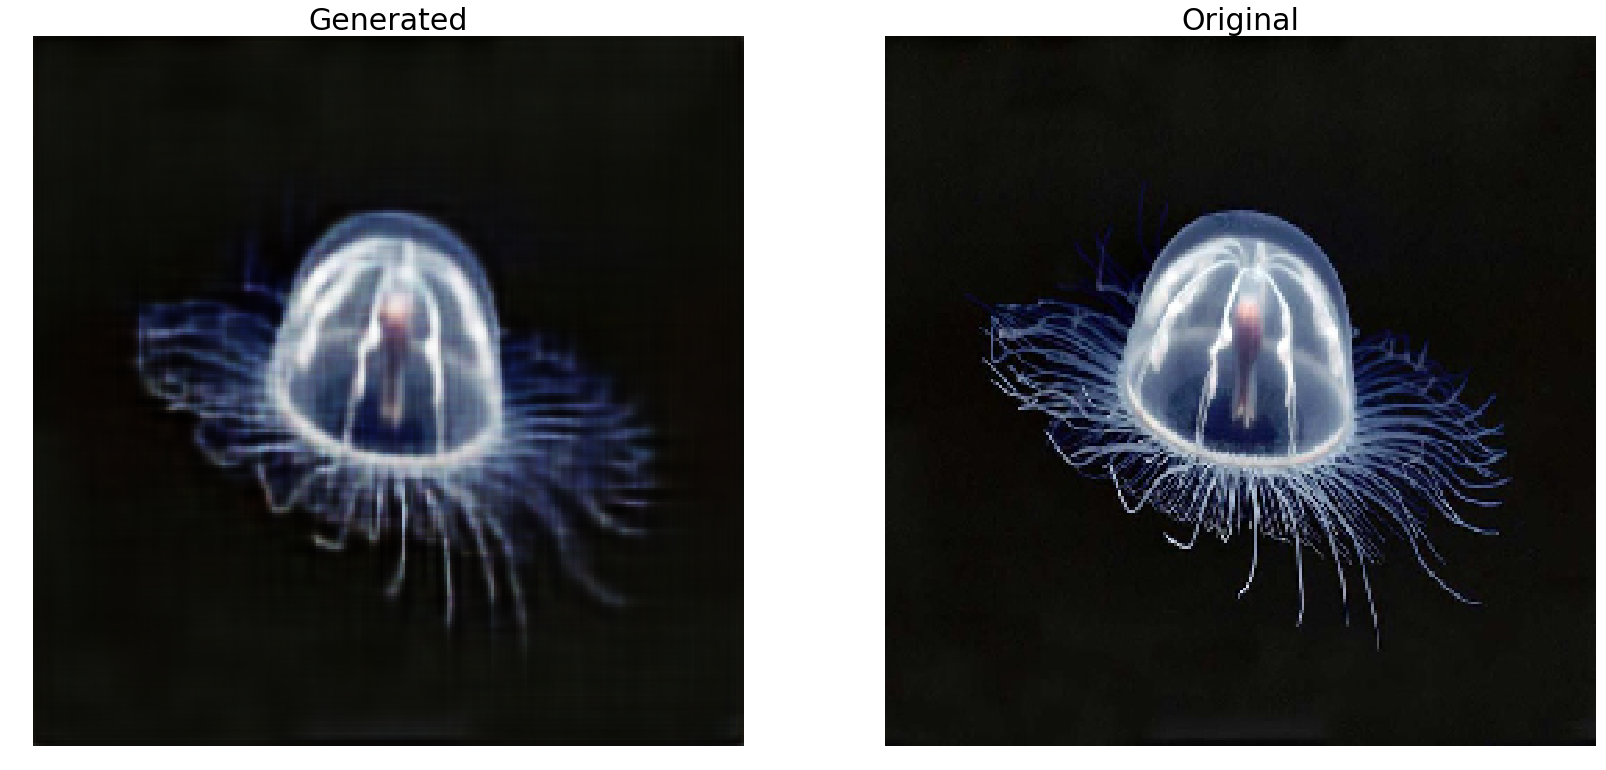

In [94]:
show_image(1)

In [53]:
decoded_img = autoencoder.predict(np.random.normal(0, 1, size=[1, 2048]))

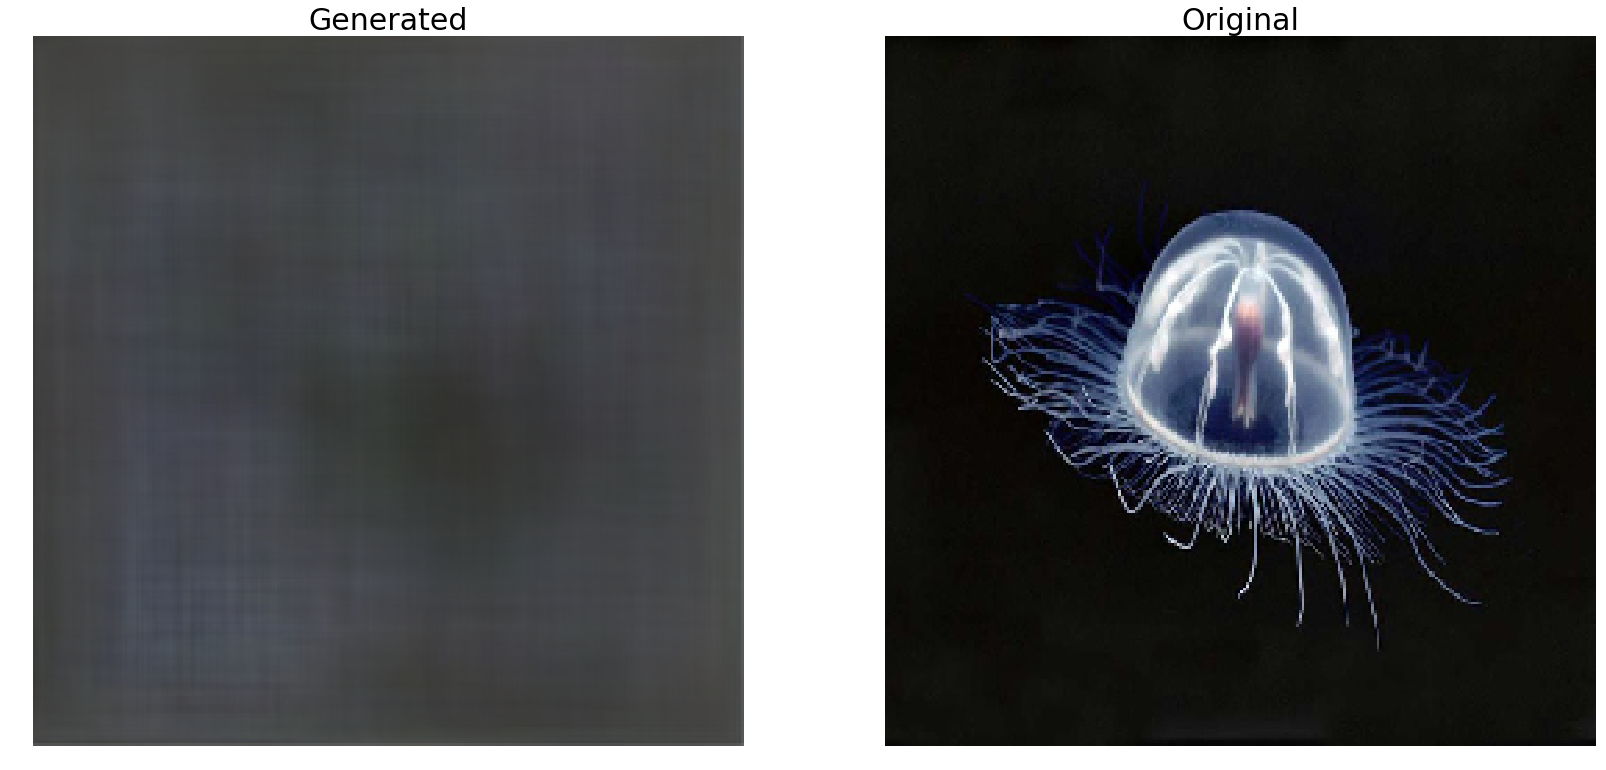

In [54]:
plt.figure(figsize=(28, 28))
plt.subplot(1, 2, 1)
plt.imshow(decoded_img.reshape(size, size, 3))
plt.title('Generated', fontsize=30)
plt.axis('off')
plt.subplot(1, 2, 2)
plt.imshow(small_out)
plt.title('Original', fontsize=30)
plt.axis('off')
#plt.tight_layout()
plt.show()